In [1]:
#import torch
import pandas as pd
import numpy as np
import json
import os
import sys
from sklearn.metrics import f1_score
import h3pandas
import torch
import h3
from sklearn.metrics import precision_recall_curve
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.metrics import brier_score_loss
import uncertainty_metrics.numpy as um


sys.path.append('../')
import datasets
import models
import utils
import setup

from sklearn.linear_model import LogisticRegression


/Users/filipdorm/opt/anaconda3/envs/sinr_icml_og/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load model
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_params = torch.load('../pretrained_models/1000_cap_models/final_loss_an_full_input_enc_sin_cos_hard_cap_num_per_class_-1/model.pt', map_location='cpu')
model = models.get_model(train_params['params'])
model.load_state_dict(train_params['state_dict'], strict=True)
model = model.to(DEVICE)
model.eval()

ResidualFCNet(
  (class_emb): Linear(in_features=256, out_features=47375, bias=False)
  (feats): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): ResLayer(
      (nonlin1): ReLU(inplace=True)
      (nonlin2): ReLU(inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (w1): Linear(in_features=256, out_features=256, bias=True)
      (w2): Linear(in_features=256, out_features=

In [3]:
if train_params['params']['input_enc'] in ['env', 'sin_cos_env']:
    raster = datasets.load_env()
else:
    raster = None
enc = utils.CoordEncoder(train_params['params']['input_enc'], raster=raster)

In [4]:
#load reference from iucn
with open(os.path.join('../data/eval/iucn/', 'iucn_res_5.json'), 'r') as f:
            data = json.load(f)
species_ids = list((data['taxa_presence'].keys()))

In [5]:
obs_locs = np.array(data['locs'], dtype=np.float32)
obs_locs = torch.from_numpy(obs_locs).to('cpu')
loc_feat = enc.encode(obs_locs)

In [6]:
classes_of_interest = torch.zeros(len(species_ids), dtype=torch.int64)
taxa_ids = torch.zeros(len(species_ids), dtype=torch.int64)
for tt_id, tt in enumerate(species_ids):
    class_of_interest = np.array([train_params['params']['class_to_taxa'].index(int(tt))])
    classes_of_interest[tt_id] = torch.from_numpy(class_of_interest)
    

In [7]:
with torch.no_grad():
    loc_emb = model(loc_feat, return_feats=True)
    wt = model.class_emb.weight[classes_of_interest, :]

In [8]:
def fscore_and_thres(y_test, preds):
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    p1 = (2 * precision * recall)
    p2 = (precision + recall)
    out = np.zeros( (len(p1)) )
    fscore = np.divide(p1,p2, out=out, where=p2!=0)
    index = np.argmax(fscore)
    thres = thresholds[index]
    max_fscore = fscore[index]
    return max_fscore, thres

In [9]:
from sklearn.calibration import calibration_curve

def plot_cal_curve(y_test, preds, calibrated_probs, taxa):
    # prob_true, prob_pred = calibration_curve(for_thres.test.values, for_thres.predictions.values, n_bins=10, strategy='uniform')
    # plt.plot(prob_pred, prob_true, marker='o', linestyle='-', color="orange")

    # Calculate calibration curve
    n_bins = 20
    prob_true, prob_pred = calibration_curve(y_test, preds, n_bins=n_bins, strategy='uniform')
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', color="royalblue")

    prob_true, prob_pred = calibration_curve(y_test, calibrated_probs, n_bins=n_bins, strategy='uniform')

    plt.plot(prob_pred, prob_true, marker='o', linestyle='--', color="royalblue")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for reference
    plt.xlabel('Mean predicted probability')
    plt.ylabel('Fraction of positives')
    plt.title(f'Calibration Curve for taxon {taxa}')
    #plt.savefig(f'./cal_curves_platt/cal_curve_{taxa}.png')
    plt.show()
    plt.close()


In [25]:
def expected_calibration_error(samples, true_labels, M=5):
    # uniform binning approach with M number of bins
    bin_boundaries = np.linspace(0, 1, M + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    # get max probability per sample i
    confidences = np.max(samples, axis=1)
    # get predictions from confidences (positional in this case)
    predicted_label = np.argmax(samples, axis=1)

    # get a boolean list of correct/false predictions
    accuracies = predicted_label==true_labels

    ece = np.zeros(1)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # determine if sample is in bin m (between bin lower & upper)
        in_bin = np.logical_and(confidences > bin_lower.item(), confidences <= bin_upper.item())
        # can calculate the empirical probability of a sample falling into bin m: (|Bm|/n)
        prob_in_bin = in_bin.mean()

        if prob_in_bin.item() > 0:
            # get the accuracy of bin m: acc(Bm)
            accuracy_in_bin = accuracies[in_bin].mean()
            # get the average confidence of bin m: conf(Bm)
            avg_confidence_in_bin = confidences[in_bin].mean()
            # calculate |acc(Bm) - conf(Bm)| * (|Bm|/n) for bin m and add to the total ECE
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prob_in_bin
    return ece

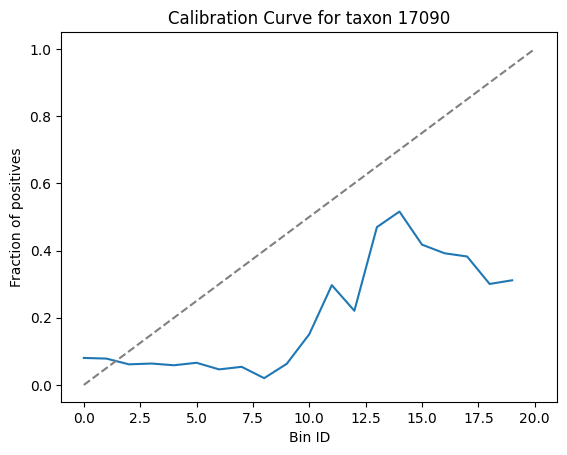

0


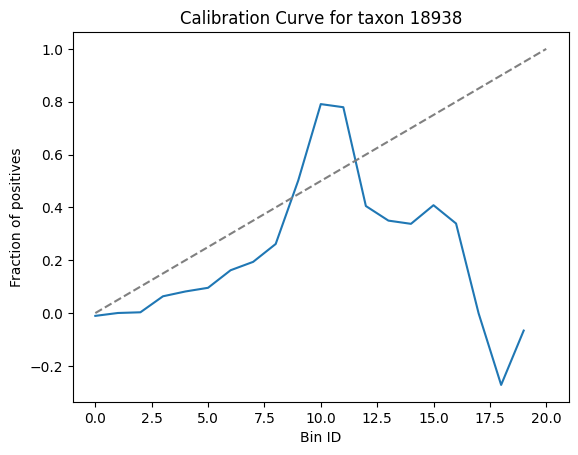

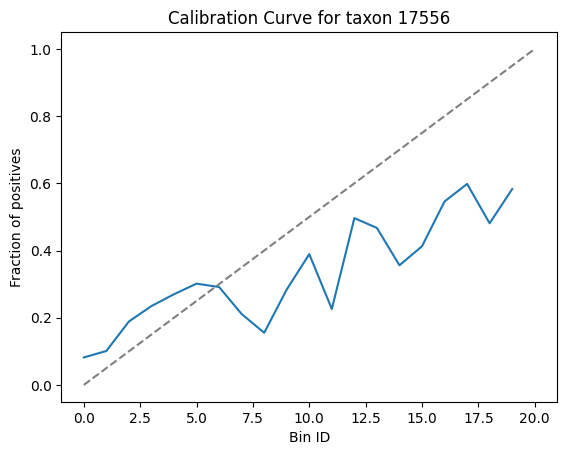

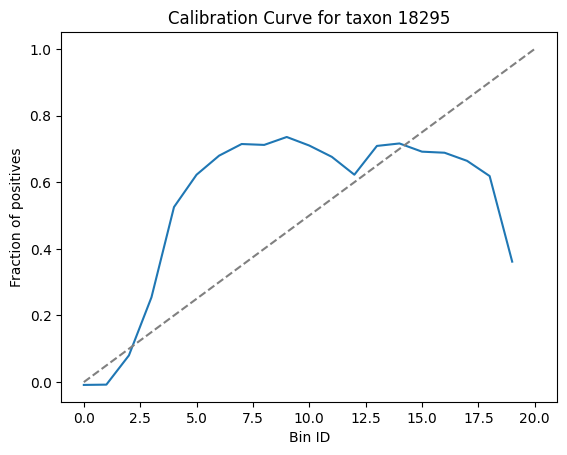

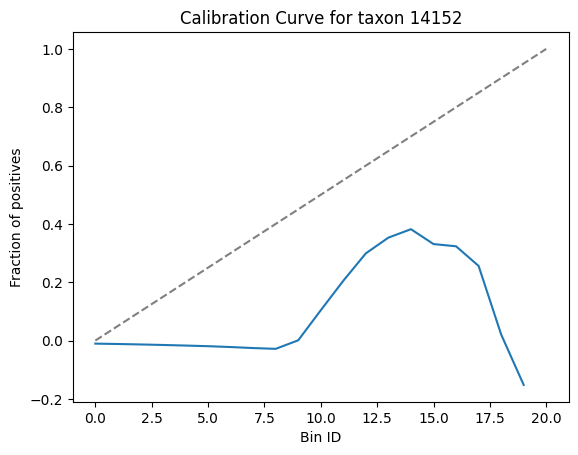

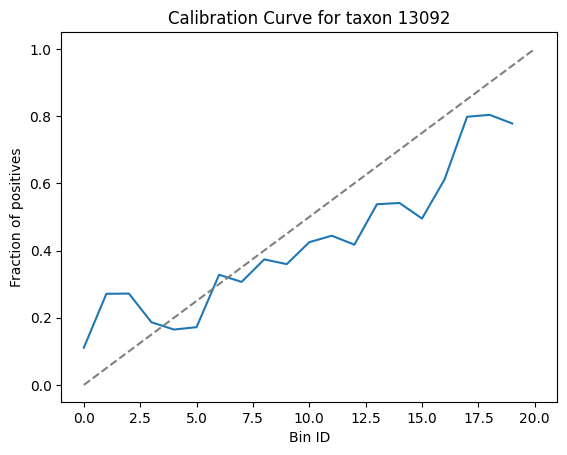

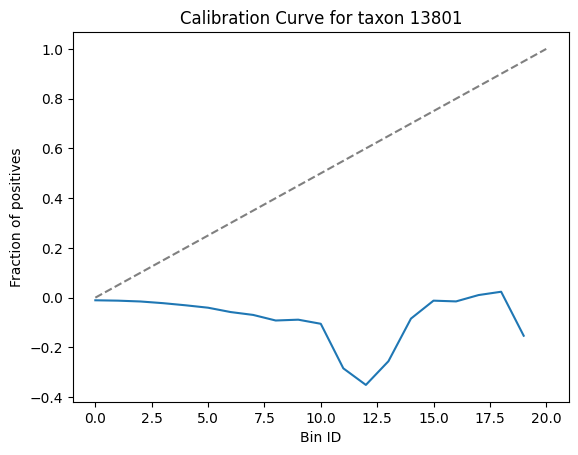

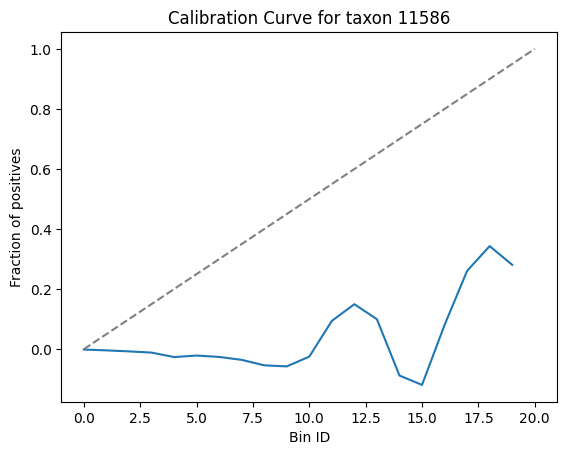

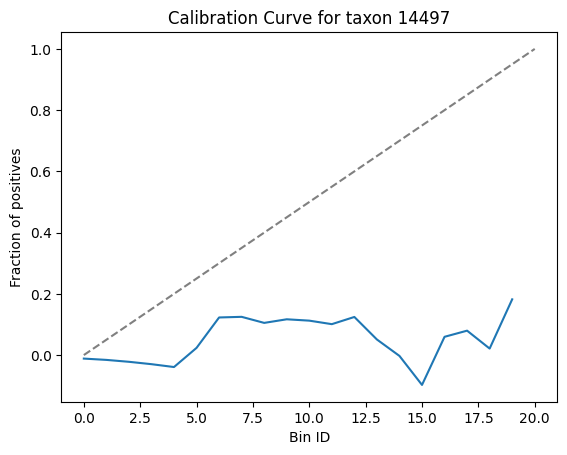

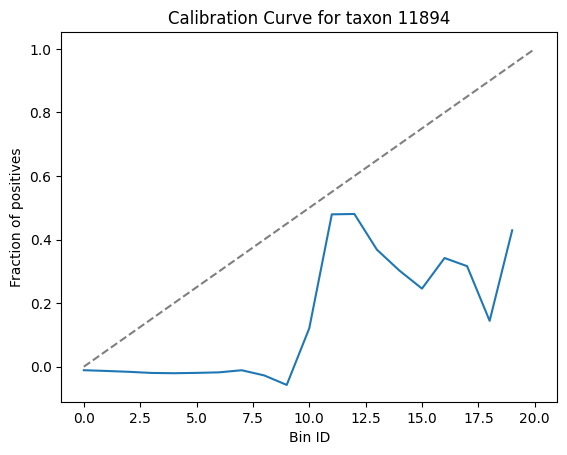

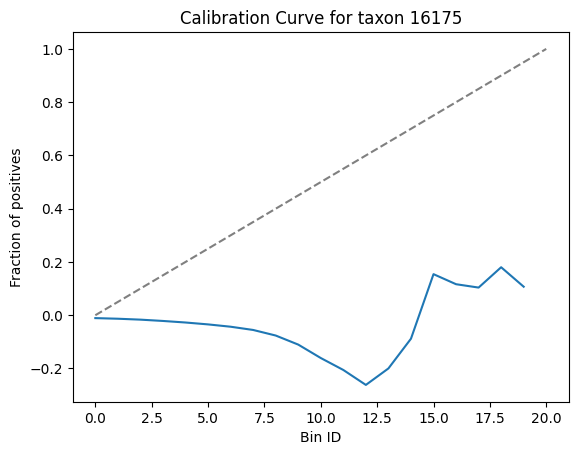

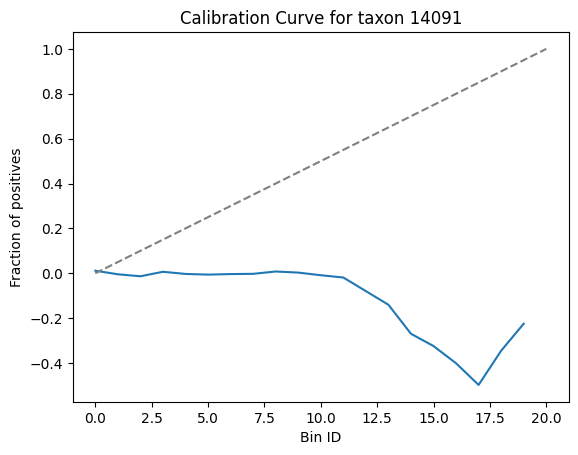

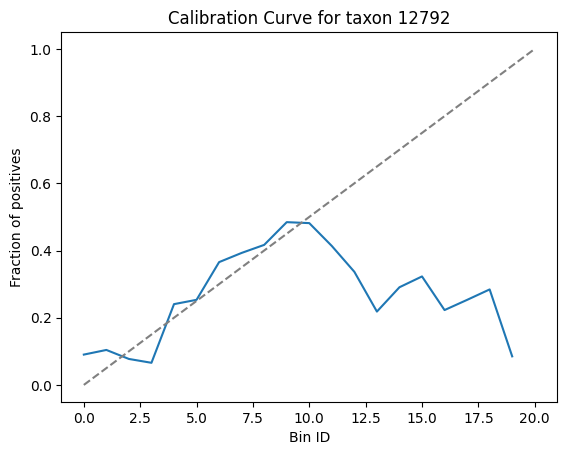

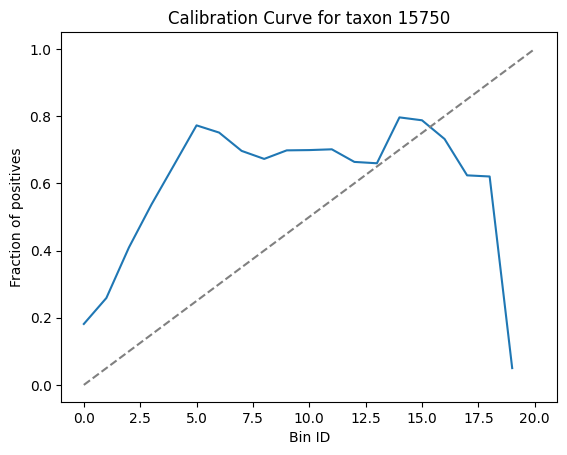

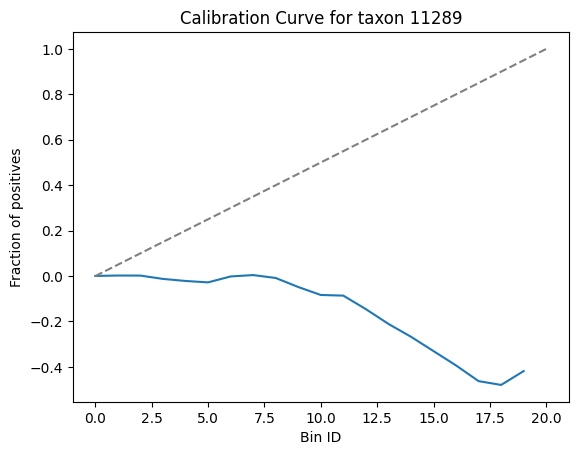

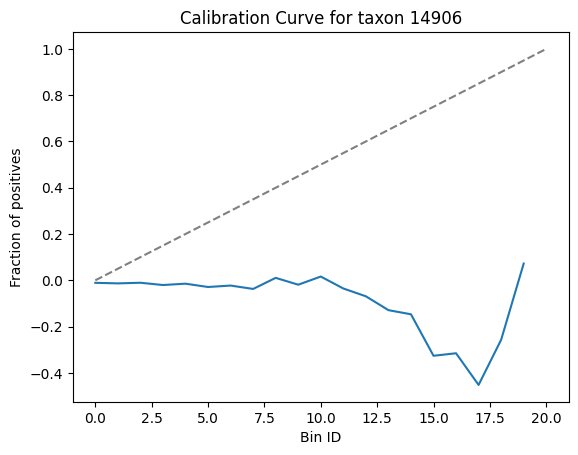

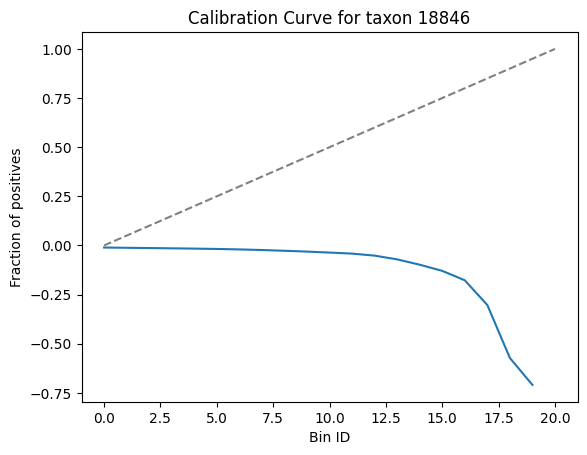

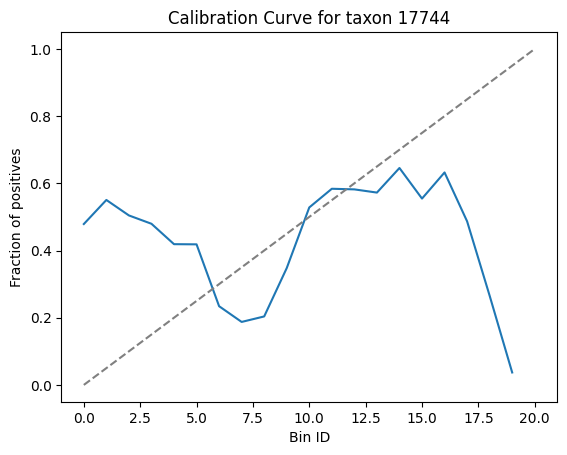

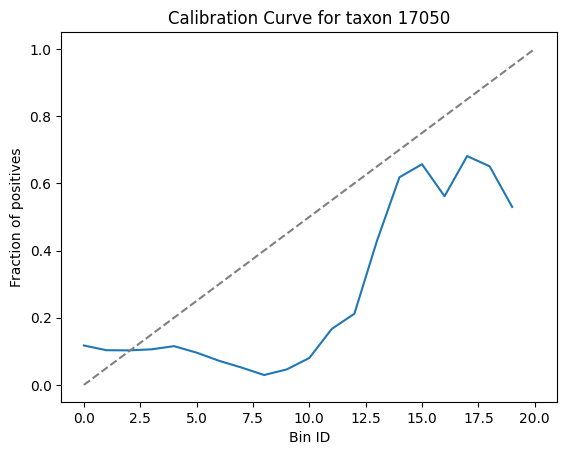

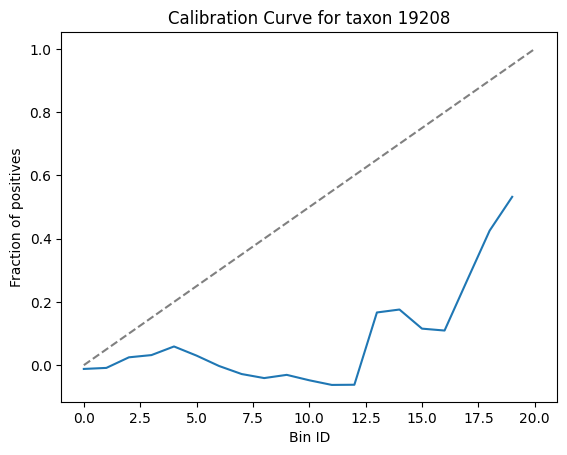

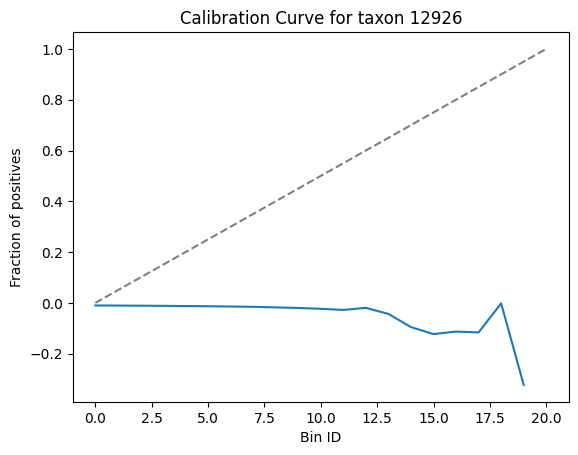

In [190]:
from sklearn.model_selection import train_test_split
output = []
for class_index, class_id in enumerate(classes_of_interest):
    wt_1 = wt[class_index,:]
    preds = torch.sigmoid(torch.matmul(loc_emb, wt_1)).cpu().numpy()
    
    taxa = species_ids[class_index]
    species_locs = data['taxa_presence'].get(str(taxa))

    truth_array = np.zeros(preds.shape, int)
    truth_array[species_locs] = 1

    #generate calibration curve data for clustering
    n_bins = 20
    y_true = truth_array
    y_prob = preds
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='uniform')
    calib_dict = dict()
    calib_dict['pred_probs'] = prob_pred
    calib_dict['emp_probs'] = prob_true


    # Compute Expected Calibration Error (ECE)
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    binids = np.searchsorted(bins[1:-1], y_prob)
    bin_total = np.bincount(binids, minlength=len(bins))
    nonzero = bin_total != 0
    ece = np.sum(np.abs(prob_true - prob_pred) * (bin_total[nonzero] / len(y_true)))

    samples = np.stack([1-y_prob, y_prob]).T
    ece2 = expected_calibration_error(samples, y_true, 20)

    # Compute Brier score
    brier_score = brier_score_loss(y_true, y_prob)

    ace = um.ace(y_true,y_prob,num_bins=20)

    TACE = um.GeneralCalibrationError(binning_scheme='adaptive',
        class_conditional=True, max_prob=False, norm='l1', threshold=0.01, num_bins=20)
    TACE.update_state(y_true,y_prob)

    tace = TACE.calibration_error

    plt.plot(TACE.accuracies - TACE.confidences)
    plt.plot([0, 20], [0, 1], linestyle='--', color='gray')  # Diagonal line for reference
    plt.xlabel('Bin ID')
    plt.ylabel('Fraction of positives')
    plt.title(f'Calibration Curve for taxon {taxa}')
    plt.show()

    row = {
        "taxon_id": taxa,
        "ece": ece,
        "brier": brier_score,
        "ace": ace,
        "tace": tace
    }
    row_dict = dict(row)
    output.append(row_dict)

    if(class_index%100==0):
            print(class_index)
    if class_index == 20: break

output_pd = pd.DataFrame(output)
    

In [ ]:
output_pd

,taxon_id,ece,brier,ace,tace
0,17090,0.001448,0.001420,0.001535,0.101937
1,18938,0.003706,0.004019,0.003254,0.129661
2,17556,0.005113,0.005202,0.005311,0.169439
3,18295,0.010052,0.008879,0.010281,0.274983
4,14152,0.000710,0.000896,0.000579,0.065041
5,13092,0.010144,0.009737,0.010555,0.215007
6,13801,0.000422,0.000498,0.000449,0.043546
7,11586,0.000181,0.000193,0.000074,0.044663
8,14497,0.001048,0.002289,0.000708,0.036419
9,11894,0.004438,0.004607,0.003864,0.087979


In [184]:
ece

6.591394418149112e-05

In [185]:
ece2

array([5.36784527e-05])

In [186]:
um.ace(y_true,y_prob,num_bins=20)

6.58209307370002e-05

In [187]:
um.tace(y_true,y_prob)

0.02555544250899861

In [188]:
um.adaptive_calibration_error(y_true,y_prob)

6.58209307433516e-05

In [153]:
TACE = um.GeneralCalibrationError(binning_scheme='adaptive',
  class_conditional=True, max_prob=False, norm='l1', threshold=0.01, num_bins=20)

In [154]:
TACE.update_state(y_true,y_prob)

In [155]:
TACE.accuracies

array([0.        , 0.01239669, 0.01654032, 0.0785124 , 0.09848485,
       0.11440386, 0.18319559, 0.21763085, 0.28856749, 0.53168044,
       0.82288077, 0.81267218, 0.44421488, 0.39972433, 0.40495868,
       0.50964187, 0.50550964, 0.32369146, 0.37767057, 0.84090909])

In [163]:
TACE.calibration_error

0.12966068958147473

In [161]:
print(TACE)

None


In [172]:
np.linspace(0,20,1)

array([0.])

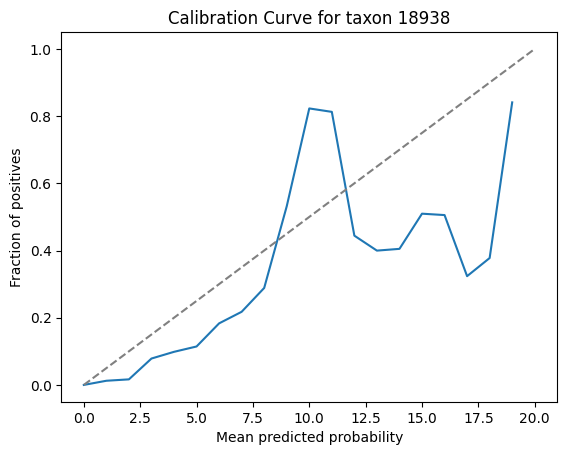

In [176]:
plt.plot(np.linspace(0,20,1),TACE.accuracies)
plt.plot([0, 20], [0, 1], linestyle='--', color='gray')  # Diagonal line for reference
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title(f'Calibration Curve for taxon {taxa}')
plt.show()

In [159]:
from scipy import stats
stats.pointbiserialr(y_true, y_prob)

SignificanceResult(statistic=0.44540589028441474, pvalue=0.0)